In [5]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [6]:
###  基准模型方法
def benchmark(clf,name):
    print (u'分类器：', clf)
    
    ##  设置最优参数，并使用5折交叉验证获取最优参数值
    alpha_can = np.logspace(-2, 1, 10)
    model = GridSearchCV(clf, param_grid={'alpha': alpha_can}, cv=5)
    m = alpha_can.size
    
    ## 如果模型有一个参数是alpha，进行设置
    if hasattr(clf, 'alpha'):
        model.set_params(param_grid={'alpha': alpha_can})
        m = alpha_can.size
    ## 如果模型有一个k近邻的参数，进行设置
    if hasattr(clf, 'n_neighbors'):
        neighbors_can = np.arange(1, 15)
        model.set_params(param_grid={'n_neighbors': neighbors_can})
        m = neighbors_can.size
    ## LinearSVC最优参数配置
    if hasattr(clf, 'C'):
        C_can = np.logspace(1, 3, 3)
        model.set_params(param_grid={'C':C_can})
        m = C_can.size
    ## SVM最优参数设置
    if hasattr(clf, 'C') & hasattr(clf, 'gamma'):
        C_can = np.logspace(1, 3, 3)
        gamma_can = np.logspace(-3, 0, 3)
        model.set_params(param_grid={'C':C_can, 'gamma':gamma_can})
        m = C_can.size * gamma_can.size
    ## 设置深度相关参数，决策树
    if hasattr(clf, 'max_depth'):
        max_depth_can = np.arange(4, 10)
        model.set_params(param_grid={'max_depth': max_depth_can})
        m = max_depth_can.size
    
    ## 模型训练
    t_start = time()
    model.fit(x_train, y_train)
    t_end = time()
    t_train = (t_end - t_start) / (5*m)
    print (u'5折交叉验证的训练时间为：%.3f秒/(5*%d)=%.3f秒' % ((t_end - t_start), m, t_train))
    print (u'最优超参数为：', model.best_params_)
    
    ## 模型预测
    t_start = time()
    y_hat = model.predict(x_test)
    t_end = time()
    t_test = t_end - t_start
    print (u'测试时间：%.3f秒' % t_test)
    
    ## 模型效果评估
    train_acc = metrics.accuracy_score(y_train, model.predict(x_train))
    test_acc = metrics.accuracy_score(y_test, y_hat)
    print (u'训练集准确率：%.2f%%' % (100 * train_acc))
    print (u'测试集准确率：%.2f%%' % (100 * test_acc))
    
    ## 返回结果(训练时间耗时，预测数据耗时，训练数据错误率，测试数据错误率, 名称)
    return t_train, t_test, 1-train_acc, 1-test_acc, name

In [ ]:
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
### 数据加载
print (u'开始下载/加载数据...')
t_start = time()
## 不要头部信息
remove = ('headers', 'footers', 'quotes')
## 只要这四类数据
categories = 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'

## 分别加载训练数据和测试数据
data_train = fetch_20newsgroups(data_home='./datas/',subset='train', categories=categories, shuffle=True, random_state=0, remove=remove)
data_test = fetch_20newsgroups(data_home='./datas/',subset='test', categories=categories, shuffle=True, random_state=0, remove=remove)

## 完成
print (u"完成数据加载过程.耗时:%.3fs" % (time() - t_start))

开始下载/加载数据...


In [ ]:
### 获取加载数据的相关信息
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

categories = data_train.target_names
data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print (u'数据类型：', type(data_train))
print("%d文本数量 - %0.3fMB (训练数据集)" % (len(data_train.data), data_train_size_mb))
print("%d文本数量 - %0.3fMB (测试数据集)" % (len(data_test.data), data_test_size_mb))
print u'训练集和测试集使用的%d个类别的名称：' % len(categories)
print(categories)

In [ ]:
### 数据重命名
x_train = data_train.data
y_train = data_train.target
x_test = data_test.data
y_test = data_test.target

In [ ]:
### 输出前5个样本
print (u' -- 前5个文本 -- ')
for i in range(5):
    print (u'文本%d(属于类别 - %s)：' % (i+1, categories[y_train[i]]))
    print (x_train[i])
    print ('\n\n')

In [ ]:
### 文档转换为向量
## 转换
vectorizer = TfidfVectorizer(input='content', stop_words='english', max_df=0.5, sublinear_tf=True)
x_train = vectorizer.fit_transform(data_train.data)  # x_train是稀疏的，scipy.sparse.csr.csr_matrix
x_test = vectorizer.transform(data_test.data)
print (u'训练集样本个数：%d，特征个数：%d' % x_train.shape)
print (u'停止词:\n')
print(vectorizer.get_stop_words())
## 获取最终的特征属性名称
feature_names = np.asarray(vectorizer.get_feature_names())

In [9]:
## 特征选择
ch2 = SelectKBest(chi2, k=1000)
x_train = ch2.fit_transform(x_train, y_train)
x_test = ch2.transform(x_test)
feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]

In [10]:
### 使用不同的分类器对数据进行比较
print (u'分类器的比较：\n')
clfs = [
    [RidgeClassifier(), 'Ridge'],
    [KNeighborsClassifier(), 'KNN'],
    [MultinomialNB(), 'MultinomialNB'],
    [BernoulliNB(), 'BernoulliNB'],
    [RandomForestClassifier(n_estimators=200), 'RandomForest'],
    [SVC(), 'SVM'],
    [LinearSVC(loss='squared_hinge', penalty='l1', dual=False, tol=1e-4), 'LinearSVC-l1'],
    [LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-4), 'LinearSVC-l2']
]

## 将训练数据保存到一个列表中
result = []
for clf,name in clfs:
    # 计算算法结果
    a = benchmark(clf,name)
    # 追加到一个列表中，方便进行展示操作
    result.append(a)
    print '\n'
## 将列表转换为数组
result = np.array(result)

分类器的比较：

分类器： RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
5折交叉验证的训练时间为：6.600秒/(5*10)=0.132秒
最优超参数为： {'alpha': 0.46415888336127775}
测试时间：0.003秒
训练集准确率：92.63%
测试集准确率：75.83%


分类器： KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
5折交叉验证的训练时间为：2.689秒/(5*14)=0.038秒
最优超参数为： {'n_neighbors': 1}
测试时间：0.098秒
训练集准确率：96.51%
测试集准确率：50.55%


分类器： MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：0.258秒/(5*10)=0.005秒
最优超参数为： {'alpha': 0.01}
测试时间：0.000秒
训练集准确率：91.40%
测试集准确率：76.72%


分类器： BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：0.299秒/(5*10)=0.006秒
最优超参数为： {'alpha': 0.01}
测试时间：0.001秒
训练集准确率：88.64%
测试集准确率：74.28%


分类器： RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
      

In [11]:
### 获取需要画图的数据
result = [[x[i] for x in result] for i in range(5)]
training_time, test_time, training_err, test_err, clf_names = result

training_time = np.array(training_time).astype(np.float)
test_time = np.array(test_time).astype(np.float)
training_err = np.array(training_err).astype(np.float)
test_err = np.array(test_err).astype(np.float)

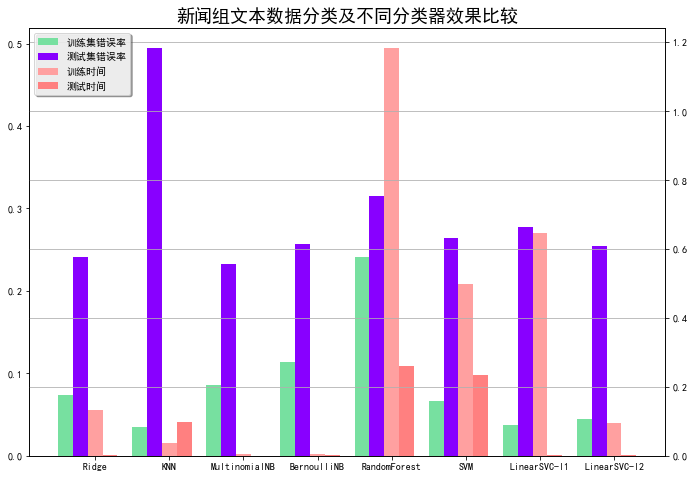

In [12]:
### 画图
x = np.arange(len(training_time))
plt.figure(figsize=(10, 7), facecolor='w')
ax = plt.axes()
b0 = ax.bar(x+0.1, training_err, width=0.2, color='#77E0A0')
b1 = ax.bar(x+0.3, test_err, width=0.2, color='#8800FF')
ax2 = ax.twinx()
b2 = ax2.bar(x+0.5, training_time, width=0.2, color='#FFA0A0')
b3 = ax2.bar(x+0.7, test_time, width=0.2, color='#FF8080')
plt.xticks(x+0.5, clf_names)
plt.legend([b0[0], b1[0], b2[0], b3[0]], (u'训练集错误率', u'测试集错误率', u'训练时间', u'测试时间'), loc='upper left', shadow=True)
plt.title(u'新闻组文本数据分类及不同分类器效果比较', fontsize=18)
plt.xlabel(u'分类器名称')
plt.grid(True)
plt.tight_layout(2)
plt.show()